# NLP Deep Dive with RNNs

In [3]:
from fastai.text.all import * 

In [4]:
path = untar_data(URLs.IMDB)

In [5]:
path.ls()

(#8) [Path('/home/jupyter/.fastai/data/imdb/test'),Path('/home/jupyter/.fastai/data/imdb/tmp_lm'),Path('/home/jupyter/.fastai/data/imdb/imdb.vocab'),Path('/home/jupyter/.fastai/data/imdb/train'),Path('/home/jupyter/.fastai/data/imdb/unsup'),Path('/home/jupyter/.fastai/data/imdb/models'),Path('/home/jupyter/.fastai/data/imdb/tmp_clas'),Path('/home/jupyter/.fastai/data/imdb/README')]

In [6]:
files = get_text_files(path, folders=['train', 'test', 'unsup'])

In [7]:
txt = files[0].open().read(); txt

"This movie was a modern day scarface.It had me on my toes.This movie is one of those rare epic films that makes you want a sequel.I especially liked Damian Chapa his performance deserved an academy award,which he deserved for his performance in blood in blood out.The only thing I didn't like was the behind the scenes because it didn't show the intensity that the movie had,and i would have like to have seen less narrated scenes.But the movie was great and it is in my top ten movies of all time.Plus the acting was great there wasn't a bad scene in the movie,I loved it ,Jennifer Tilly was perfect as well as all of the cast.I can't see how anyone wouldn't like this movie it was a great.Definitely a must see."

## Tokenization

In [8]:
spacy = WordTokenizer()
spacy

In [9]:
# spacy tokenizes our text with the deafult settings here, tokenizing by spaces 
toks = first(spacy([txt])); toks

(#160) ['This','movie','was','a','modern','day','scarface','.','It','had'...]

In [10]:
type(toks)

fastcore.foundation.L

In [11]:
# hmm is this fastai function really necessary? just gets a string representation to show more values... 🤷‍♀️
coll_repr(toks, 50)

"(#160) ['This','movie','was','a','modern','day','scarface','.','It','had','me','on','my','toes','.','This','movie','is','one','of','those','rare','epic','films','that','makes','you','want','a','sequel','.','I','especially','liked','Damian','Chapa','his','performance','deserved','an','academy','award',',','which','he','deserved','for','his','performance','in'...]"

In [12]:
# now lets use fastai's tokenizer 
tkn = Tokenizer(spacy)
coll_repr(tkn(txt), 50)
# we see fastai's special tokens representing "beginning of stream", "capital letter incoming!" etc. 

"(#149) ['xxbos','xxmaj','this','movie','was','a','modern','day','scarface.it','had','me','on','my','toes.this','movie','is','one','of','those','rare','epic','films','that','makes','you','want','a','sequel.i','especially','liked','xxmaj','damian','xxmaj','chapa','his','performance','deserved','an','academy','award',',','which','he','deserved','for','his','performance','in','blood','in'...]"

In [13]:
list(tkn('hello I\'m going to use an invalid english word tootyfruitcake'))

['xxbos',
 'hello',
 'xxmaj',
 'i',
 "'m",
 'going',
 'to',
 'use',
 'an',
 'invalid',
 'english',
 'word',
 'tootyfruitcake']

In [14]:
coll_repr(tkn('&copy;     Fast.ai www.fast.ai/INDEX'), 31)

"(#11) ['xxbos','©','xxmaj','fast.ai','xxrep','3','w','.fast.ai','/','xxup','index']"

## Subword Tokenization

In [15]:
txts = L(f.open().read() for f in files[:2000])

In [16]:
len(txts)

2000

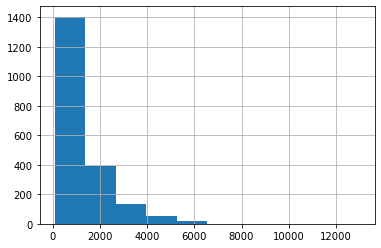

In [17]:
pd.Series([len(t) for t in txts]).hist();

In [18]:
! pip install sentencepiece!=0.1.90,!=0.1.91

In [19]:
sp = SubwordTokenizer(vocab_sz=1000)
sp

In [20]:
sp.setup(txts)
" ".join(first(sp([txt]))[:40])

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=tmp/texts.out --vocab_size=1000 --model_prefix=tmp/spm --character_coverage=0.99999 --model_type=unigram --unk_id=9 --pad_id=-1 --bos_id=-1 --eos_id=-1 --minloglevel=2 --user_defined_symbols=▁xxunk,▁xxpad,▁xxbos,▁xxeos,▁xxfld,▁xxrep,▁xxwrep,▁xxup,▁xxmaj --hard_vocab_limit=false


'▁This ▁movie ▁was ▁a ▁mo der n ▁day ▁sc ar f a ce . I t ▁had ▁me ▁on ▁my ▁to es . This ▁movie ▁is ▁one ▁of ▁those ▁ra re ▁e p ic ▁films ▁that ▁makes ▁you ▁want ▁a'

In [21]:
def subword(sz):
  """
  tokenizes our hardcoded text with a given subword token size 
  """
  sp = SubwordTokenizer(vocab_sz=sz)
  sp.setup(txts)
  return " ".join(first(sp([txt]))[:40])

In [22]:
subword(200)

'▁ T h i s ▁movie ▁was ▁a ▁mo d er n ▁ d a y ▁ s c ar f a ce . I t ▁h a d ▁ m e ▁on ▁ m y ▁to es . T'

## Numericalization

We need to map each token to an index so we can represent words in our model 

In [23]:
tkn(txts[0])

(#149) ['xxbos','xxmaj','this','movie','was','a','modern','day','scarface.it','had'...]

In [24]:
# tokenize the first 200 documents 
toks200 = txts[:200].map(tkn)
toks200[0]

(#149) ['xxbos','xxmaj','this','movie','was','a','modern','day','scarface.it','had'...]

In [25]:
# set indices for the tokens that occur in the first 200 documents
num = Numericalize()
num.setup(toks200)
list(num.vocab)[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the']

In [26]:
toks = toks200[0] 
nums = num(toks)[:50]; nums

TensorText([   2,    8,   20,   27,   25,   13,  628,  203,    0,   86,   83,
              36,   73,    0,   27,   15,   39,   14,  150,  711, 1034,  148,
              21,  162,   33,  191,   13,    0,  265,  304,    8,    0,    8,
               0,   35,  239,  512,   49,    0,    0,   11,   89,   34,  512,
              28,   35,  239,   17, 1035,   17])

In [27]:
' '.join(num.vocab[i] for i in nums)

'xxbos xxmaj this movie was a modern day xxunk had me on my xxunk movie is one of those rare epic films that makes you want a xxunk especially liked xxmaj xxunk xxmaj xxunk his performance deserved an xxunk xxunk , which he deserved for his performance in blood in'

In [28]:
txts[0]

"This movie was a modern day scarface.It had me on my toes.This movie is one of those rare epic films that makes you want a sequel.I especially liked Damian Chapa his performance deserved an academy award,which he deserved for his performance in blood in blood out.The only thing I didn't like was the behind the scenes because it didn't show the intensity that the movie had,and i would have like to have seen less narrated scenes.But the movie was great and it is in my top ten movies of all time.Plus the acting was great there wasn't a bad scene in the movie,I loved it ,Jennifer Tilly was perfect as well as all of the cast.I can't see how anyone wouldn't like this movie it was a great.Definitely a must see."

## Put the numbers in a model 

In [29]:
nums200 = toks200.map(num)
nums200[0]

TensorText([   2,    8,   20,   27,   25,   13,  628,  203,    0,   86,   83,
              36,   73,    0,   27,   15,   39,   14,  150,  711, 1034,  148,
              21,  162,   33,  191,   13,    0,  265,  304,    8,    0,    8,
               0,   35,  239,  512,   49,    0,    0,   11,   89,   34,  512,
              28,   35,  239,   17, 1035,   17, 1035,    0,   88,  192,   19,
             110,   40,   52,   25,    9,  712,    9,  164,  127,   18,  110,
              40,   99,    9,    0,   21,    9,   27,   86,   11,   12,   19,
              78,   47,   52,   16,   47,  121,  713,    0,    0,    9,   27,
              25,   63,   12,   18,   15,   17,   73,  325,  854,  105,   14,
              46,    0,    9,  142,   25,   63,   56,   25,   40,   13,  193,
             194,   17,    9,   27,   11,   19,  251,   18,   11, 1323,    8,
               0,   25,  289,   24,   80,   24,   46,   14,    9,    0,  227,
              40,   69,  103,  209,   78,   40,   52,   20,   27

In [30]:
# language model dataloader
# LMDataLoader??

In [31]:
dl = LMDataLoader(nums200)

In [32]:
x, y = first(dl)
x.shape, y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

In [33]:
x

LMTensorText([[   2,    8,   20,  ...,    0,   21,    9],
              [   9,  721,   43,  ...,   49, 1047,   78],
              [  13,  253,    0,  ...,    0,   37,   10],
              ...,
              [   8,   63,  105,  ...,  648,    9,  701],
              [ 147,   37,   15,  ...,    8,   19,  160],
              [  27,    8,    0,  ...,   47,   70,  437]])

In [34]:
# LmTensorText -> TensorText -> TensorBase (fastai) -> Tensor (pytorch)
# TensorBase??

In [35]:
 %pprint

Pretty printing has been turned OFF


In [36]:
[num.vocab[a] for a in x[0,:]]

['xxbos', 'xxmaj', 'this', 'movie', 'was', 'a', 'modern', 'day', 'xxunk', 'had', 'me', 'on', 'my', 'xxunk', 'movie', 'is', 'one', 'of', 'those', 'rare', 'epic', 'films', 'that', 'makes', 'you', 'want', 'a', 'xxunk', 'especially', 'liked', 'xxmaj', 'xxunk', 'xxmaj', 'xxunk', 'his', 'performance', 'deserved', 'an', 'xxunk', 'xxunk', ',', 'which', 'he', 'deserved', 'for', 'his', 'performance', 'in', 'blood', 'in', 'blood', 'xxunk', 'only', 'thing', 'i', 'did', "n't", 'like', 'was', 'the', 'behind', 'the', 'scenes', 'because', 'it', 'did', "n't", 'show', 'the', 'xxunk', 'that', 'the']

In [37]:
[num.vocab[a] for a in y[0,:]]

['xxmaj', 'this', 'movie', 'was', 'a', 'modern', 'day', 'xxunk', 'had', 'me', 'on', 'my', 'xxunk', 'movie', 'is', 'one', 'of', 'those', 'rare', 'epic', 'films', 'that', 'makes', 'you', 'want', 'a', 'xxunk', 'especially', 'liked', 'xxmaj', 'xxunk', 'xxmaj', 'xxunk', 'his', 'performance', 'deserved', 'an', 'xxunk', 'xxunk', ',', 'which', 'he', 'deserved', 'for', 'his', 'performance', 'in', 'blood', 'in', 'blood', 'xxunk', 'only', 'thing', 'i', 'did', "n't", 'like', 'was', 'the', 'behind', 'the', 'scenes', 'because', 'it', 'did', "n't", 'show', 'the', 'xxunk', 'that', 'the', 'movie']

So the "label" is just the same sequence but offset by one token, i.e. containing the final "completed" token for the sequence. Interesting... 

From book RE using built-in APIs to handle numericalization and tokenization. i.e., you don't actually have to manually set up these steps, they're built into TextBLock 

*fastai handles tokenization and numericalization automatically when TextBlock is passed to DataBlock. All of the arguments that can be passed to Tokenize and Numericalize can also be passed to TextBlock. In the next chapter we'll discuss the easiest ways to run each of these steps separately, to ease debugging—but you can always just debug by running them manually on a subset of your data as shown in the previous sections. And don't forget about DataBlock's handy summary method, which is very useful for debugging data issues.*

In [38]:
# returns a list of file paths given the imdb base path 
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

In [39]:
# data loaders: language model

dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, 
    splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=128, seq_len=80)

In [40]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos a new side to the story of xxmaj victoria and xxmaj albert is brought to life by director jean - marc xxmaj xxunk . xxmaj most people 's cursory thoughts of xxmaj queen xxmaj victoria is that of woman who reigned for several decades and lived her life in mourning . xxmaj emily xxmaj blunt is more than capable in the title role as she gives audiences a different perspective . xxmaj she portrays xxmaj victoria in her youth,"a new side to the story of xxmaj victoria and xxmaj albert is brought to life by director jean - marc xxmaj xxunk . xxmaj most people 's cursory thoughts of xxmaj queen xxmaj victoria is that of woman who reigned for several decades and lived her life in mourning . xxmaj emily xxmaj blunt is more than capable in the title role as she gives audiences a different perspective . xxmaj she portrays xxmaj victoria in her youth ,"
1,"the inside of a snow - globe , but xxmaj farrow gets a startling dose of reality after he admits he 's hired a man to kill her . xxmaj she flees into the night , taking refuge with a very strange couple who want to help her rebuild her life . xxmaj the production design and art direction of "" reckless "" are fine , but they are services rendered for a completely inane , often alienating screenplay .","inside of a snow - globe , but xxmaj farrow gets a startling dose of reality after he admits he 's hired a man to kill her . xxmaj she flees into the night , taking refuge with a very strange couple who want to help her rebuild her life . xxmaj the production design and art direction of "" reckless "" are fine , but they are services rendered for a completely inane , often alienating screenplay . xxmaj"


### Let's train the damn thing

In [41]:
# AWD_LSTM??

In [42]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [42]:
# NOTE language_model_learner automatically freezes the parameters of the pretrained model, adding new 
# parameters for any new tokens in the vocab 

# we illustrate this below by showing that most parameters do not have gradients enabled 
for param in learn.model.parameters():
    print(param.requires_grad)

True
False
False
False
False
False
False
False
False
False
False
False
False
True


In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time


In [47]:
learn.predict("this movie was", n_words=50)

"this movie was alright . It is not bad . \n\n The story revolved around what happened , and one problem did n't get clear . \n\n It 's sick especially about a young scientist to meet up with Eva as the commander of the vital submarine ( indeed"

In [48]:
learn.predict("the worst", n_words=50)

'the worst Hollywood movie ever . a subtle script concerning an corporation based on Foxtel as a means to gain money . \n\n This film would sadly volunteer for the record and is not just worth a look , as in Trainspotting . \n\n Still it is'

In [49]:
learn.predict("the best", n_words=50)

'the best TV movie ever made for TV . This film is either done or produced by anyone who does already know it . The endless critics of Alfred Hitchcock in a leading role have no letting seen anyone else . The only truth'

In [50]:
learn.predict("", n_words=50, temperature=0.7)

"In this movie , i was expecting a good movie . The movie was a disappointment , and i ca n't believe it was a total waste of time . It was a terrible waste of time . Every episode of this show was OK"

Damn, looks like our model is saying things about movies!

In [ ]:
learn.save('1epoch') 

In [46]:
learn = learn.load('1epoch') 

In [ ]:
learn.unfreeze()

In [ ]:
for param in learn.model.parameters():
    print(param.requires_grad)

In [ ]:
learn.fit_one_cycle(10,2e-3)

In [ ]:
learn.predict("", n_words=200, temperature=0.7)

In [ ]:
learn.save('unfreeze')

In [51]:
learn = learn.load('unfreeze')

In [52]:
learn.predict("", n_words=100, temperature=0.7)

'a huge fan of The Great Outdoors , i was expecting a movie that i could watch again and again , but i was disappointed . The movie starts off with a delightful surprise , and it is very well - done ! The characters are very funny , the situations are hilarious and the film is almost as funny as the original Grease . The acting was very good , especially John Travolta as Abbot Creed , and the music was excellent . The film was really'